In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import sys
sys.path.insert(1, "../python/functions")
sys.path.insert(2, "../python/architecture")

In [3]:
from data_prep_functions import wine_prep
from model_functions import *
from plotting_functions import *
import no_gpu
import reproducible
from sklearn.metrics import mean_squared_error

In [4]:
import time

In [5]:
X_train, X_test, y_train, y_test = wine_prep()

In [6]:
layers = 4
neurons = [32, 32, 16, 1]
n_cols = X_train.shape[1]
batch_size = 200
epochs = 20
optimizer = "adam"

Epoch 1/20
21/21 [==============================] - 0s 12ms/step - loss: 15.9139 - mse: 15.9139 - val_loss: 11.8172 - val_mse: 11.8172
Epoch 2/20
21/21 [==============================] - 0s 5ms/step - loss: 8.2022 - mse: 8.2022 - val_loss: 4.2940 - val_mse: 4.2940
Epoch 3/20
21/21 [==============================] - 0s 6ms/step - loss: 3.0623 - mse: 3.0623 - val_loss: 2.2135 - val_mse: 2.2135
Epoch 4/20
21/21 [==============================] - 0s 7ms/step - loss: 2.0158 - mse: 2.0158 - val_loss: 1.6136 - val_mse: 1.6136
Epoch 5/20
21/21 [==============================] - 0s 7ms/step - loss: 1.5648 - mse: 1.5648 - val_loss: 1.3201 - val_mse: 1.3201
Epoch 6/20
21/21 [==============================] - 0s 7ms/step - loss: 1.2730 - mse: 1.2730 - val_loss: 1.1145 - val_mse: 1.1145
Epoch 7/20
21/21 [==============================] - 0s 10ms/step - loss: 1.0813 - mse: 1.0813 - val_loss: 0.9738 - val_mse: 0.9738
Epoch 8/20
21/21 [==============================] - 0s 9ms/step - loss: 0.9523 - mse

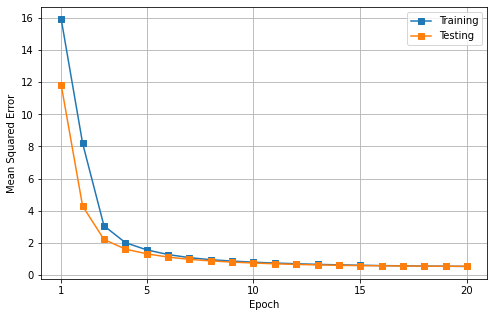

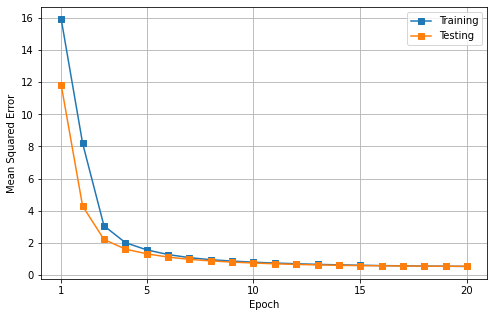

In [88]:
model = nn_model_structure(layers = layers,
                           neurons = neurons,
                           n_cols = n_cols,
                           classification = False)
model = nn_model_compile(model,
                         optimizer = optimizer)
start_time = time.time()
model = nn_model_fit(model,
                     X_train,
                     y_train,
                     X_val = X_test,
                     y_val = y_test,
                     batch_size = batch_size,
                     epochs = epochs)
end_time = time.time()
print("Overall calculation took {} seconds.".format(end_time - start_time))
model.summary()
nn_plot_mse(model,
            mse_mean = None,
            start_epoch = 1,
            savefig = True,
            file = "../img/wine/wine_{}_E{}_B{}.png".format(optimizer, epochs, batch_size))
nn_save(model,
        "../models/wine/wine_{}_E{}_B{}.h5".format(optimizer, epochs, batch_size))
#model = nn_load("../models/wine/wine_{}_E{}_B{}.h5".format(optimizer, epochs, batch_size))
nn_plot_mse(model,
            mse_mean = None,
            start_epoch = 1,
            savefig = True,
            file = "../img/wine/wine_{}_E{}_B{}.png".format(optimizer, epochs, batch_size))

In [130]:
def nn_plot_mse_many(model_list,
                     label_list,
                     train_test = "train",
                     mse_mean = None,       # mean_squared_error(y_train, np.ones(shape = (len(y_train),))*np.mean(y_train))
                     start_epoch = 1,
                     title = "",
                     savefig = False,
                     file = "../img/mse.png"
                    ):

    """ Function to plot the evolution of the mean squared error of
    the neural network.


    Parameters:

    model_list (list of tensorflow.python.keras.engine.sequential.Sequential): Some fitted models.
    label_list (list of str): Labels for the plotted model MSEs in the legend of the plot.
    train_test (str): Which MSEs to plot. Can be either "train", "test" or "both".
    mse_mean (float or None): MSE when always predicting the mean of the target.
    start_epoch (int): Epoch to start the plot with. Helpful for better visibility if the first MSEs are much higher than the later ones.
    title (str): Title of the plot.
    savefig (bool): Whether or not to save the plot.
    file (str): Path and filename if savefig is True.


    """
    
    train_mses_dict = {}
    test_mses_dict = {}
    
    for i, model in enumerate(model_list):
        try:
            model.history.history
        except:
            # if model is loaded
            train_mse_list = list(model.history["mse"])
            test_mse_list = list(model.history["val_mse"])
            if len(model.history) == 4:
                train_mse_list = np.concatenate([[0], train_mse_list])
                test_mse_list = np.concatenate([[0], test_mse_list])
        else:
            # if model is not loaded but built within the current session
            train_mse_list = model.history.history["mse"]
            test_mse_list = model.history.history["val_mse"]
            train_mse_list = np.concatenate([[0], train_mse_list])
            test_mse_list = np.concatenate([[0], test_mse_list])
        
        train_mses_dict["model_{}".format(str(i+1))] = train_mse_list
        test_mses_dict["model_{}".format(str(i+1))] = test_mse_list

    stop_tick = int(np.ceil((len(train_mses_dict["model_1"]) - 1) / 5) * 5)
    num_round = int(np.ceil((len(train_mses_dict["model_1"]) - 1) / 5) + 1)

    xticks = np.linspace(start = 0,
                         stop = stop_tick,
                         num = num_round)
    xticks = np.delete(xticks, np.where(xticks <= start_epoch))
    xticks = np.append(xticks, [start_epoch])

    plt.figure(figsize = (8,5))
    for i in range(len(model_list)):
        if train_test == "train":
            plt.plot(np.arange(len(train_mses_dict["model_{}".format(str(i+1))]))[start_epoch:] , train_mses_dict["model_{}".format(str(i+1))][start_epoch:], label = label_list[i])
        elif train_test == "test":    
            plt.plot(np.arange(len(test_mses_dict["model_{}".format(str(i+1))]))[start_epoch:] , test_mses_dict["model_{}".format(str(i+1))][start_epoch:], label = label_list[i])
        elif train_test == "both":
            plt.plot(np.arange(len(train_mses_dict["model_{}".format(str(i+1))]))[start_epoch:] , train_mses_dict["model_{}".format(str(i+1))][start_epoch:], label = label_list[i])
            plt.plot(np.arange(len(test_mses_dict["model_{}".format(str(i+1))]))[start_epoch:] , test_mses_dict["model_{}".format(str(i+1))][start_epoch:], label = label_list[i])
    if mse_mean is not None:
        plt.hlines(y = mse_mean,
                   xmin = start_epoch,
                   xmax = len(train_mses_dict["model_1"])-1,
                   color = "black",
                   label = "Mean as prediction")
    plt.legend(loc = "upper right")
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Mean Squared Error")
    plt.xticks(ticks = xticks)
    plt.grid()
    if savefig:
        plt.savefig(file)
    plt.show()

In [121]:
model_1 = nn_load("../models/wine/wine_adagrad_E20_B200.h5")
model_2 = nn_load("../models/wine/wine_adam_E20_B200.h5")

In [122]:
model_list = [model_1,
              model_2]
label_list = ["Adagrad",
              "Adam"]

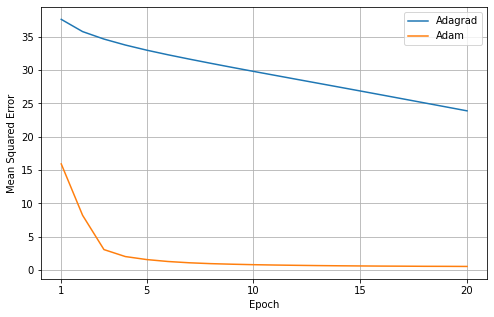

In [134]:
nn_plot_mse_many(model_list,
                 label_list,
                 train_test = "train",
                 mse_mean = None,
                 start_epoch = 1,
                 savefig = False,
                 file = "../img/wine/wine_{}_E{}_B{}.png".format(optimizer, epochs, batch_size))

In [84]:
def nn_load(path_name):

    """ Function to load a neural network model and its history.


    Parameters:

    path_name (str): Where to find the model. Is a .h5-file.



    Returns:

    model (tensorflow.python.keras.engine.sequential.Sequential): Some model.


    """

    model = tensorflow.python.keras.models.load_model(path_name)

    history_path = path_name.replace("models",
                                     "objects").\
                                replace(".h5",
                                        "_history.pckl")

    object_path = path_name.replace("models",
                                    "objects").\
                                replace("h5",
                                        "pckl")

    if os.path.exists(history_path):
        f = open(history_path, "rb")
        model.history = pickle.load(f)
        f.close()

        model.epoch = list(np.arange(len(list(model.history.values())[0])))

    if os.path.exists(object_path):
        obj_dict = load_objects(object_path)
        if list(obj_dict["results"].keys())[0][-3:] == "mse":
            train_hist = obj_dict["results"]["mean_model_train_mse"]
            test_hist = obj_dict["results"]["mean_model_test_mse"]
            hist_dict = {"mse": train_hist,
                         "val_mse": test_hist}
        else:
            train_hist = obj_dict["results"]["mean_model_train_acc"]
            test_hist = obj_dict["results"]["mean_model_test_acc"]
            hist_dict = {"accuracy": train_hist,
                         "val_accuracy": test_hist}
        model.history = hist_dict

        model.epoch = list(np.arange(len(list(model.history.values())[0])))

    return model

In [118]:
def nn_plot_epoch_mse1(model,
                      mse_mean = None, # mean_squared_error(y_train, np.ones(shape = (len(y_train),))*np.mean(y_train))
                      start_epoch = 1,
                      title = "",
                      savefig = False,
                      img_file = "../img/accuracy_per_epoch.png"
                      ):

    """ Function to plot the evolution of the mean squared error of the
    neural network per iteration.


    Parameters:

    model (tensorflow.python.keras.engine.sequential.Sequential): Some fitted model.
    mse_mean (float or None): MSE when always predicting the mean of the target.
    title (str): Title of the plot.
    savefig (bool): Whether or not to save the plot.
    file (str): Path and filename if savefig is True.


    """
    
    try:
        model.history.history
    except:
        # if model is loaded
        train_mse_list = list(model.history["mse"])
        test_mse_list = list(model.history["val_mse"])
        if len(model.history) == 4:
            train_mse_list = np.concatenate([[0], train_mse_list])
            test_mse_list = np.concatenate([[0], test_mse_list])
    else:
        # if model is not loaded but built within the current session
        train_mse_list = model.history.history["mse"]
        test_mse_list = model.history.history["val_mse"]
        train_mse_list = np.concatenate([[0], train_mse_list])
        test_mse_list = np.concatenate([[0], test_mse_list])

    stop_tick = int(np.ceil((len(train_mse_list) - 1) / 5) * 5)
    num_round = int(np.ceil((len(train_mse_list) - 1) / 5) + 1)

    xticks = np.linspace(start = 0,
                         stop = stop_tick,
                         num = num_round)
    xticks = np.delete(xticks, np.where(xticks <= start_epoch))
    xticks = np.append(xticks, [start_epoch])

    plt.figure(figsize = (8,5))
    plt.plot(np.arange(len(train_mse_list))[start_epoch:] , train_mse_list[start_epoch:], label = "Training", marker = "s")
    plt.plot(np.arange(len(test_mse_list))[start_epoch:], test_mse_list[start_epoch:], label = "Testing", marker = "s")
    if mse_mean is not None:
        plt.hlines(y = mse_mean,
                   xmin = start_epoch,
                   xmax = len(train_mse_list) - 1,
                   color = "black",
                   label = "Random guessing")
    plt.legend(loc = "upper right")
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Mean Squared Error")
    plt.xticks(ticks = xticks)
    plt.grid()
    if savefig:
        plt.savefig(img_file)
    plt.show()

In [108]:
model_1 = nn_load("../models/wine/enkf_wine_full_E20_B200_P100_H2.h5")
model_2 = nn_load("../models/wine/wine_adam_E20_B200.h5")

In [65]:
np.concatenate([[0], train_mse_list])

array([ 0.        , 23.59680176, 12.5900898 ,  4.60226917,  2.616364  ,
        2.03547454,  1.72127616,  1.50060594,  1.31787133,  1.16394401,
        1.02440464,  0.9059552 ,  0.80812013,  0.72662622,  0.66903538,
        0.62776303,  0.60336548,  0.58307451,  0.56829149,  0.56137383,
        0.54759222])

In [78]:
train_mse_list = list(model_2.history["mse"])
test_mse_list = list(model_2.history["val_mse"])

In [79]:
train_mse_list

[23.5968017578125,
 12.590089797973633,
 4.602269172668457,
 2.616364002227783,
 2.0354745388031006,
 1.7212761640548706,
 1.5006059408187866,
 1.317871332168579,
 1.1639440059661865,
 1.0244046449661255,
 0.9059551954269409,
 0.8081201314926147,
 0.7266262173652649,
 0.6690353751182556,
 0.627763032913208,
 0.6033654808998108,
 0.5830745100975037,
 0.5682914853096008,
 0.5613738298416138,
 0.5475922226905823]

In [55]:
list(model_2.history["mse"])

[23.5968017578125,
 12.590089797973633,
 4.602269172668457,
 2.616364002227783,
 2.0354745388031006,
 1.7212761640548706,
 1.5006059408187866,
 1.317871332168579,
 1.1639440059661865,
 1.0244046449661255,
 0.9059551954269409,
 0.8081201314926147,
 0.7266262173652649,
 0.6690353751182556,
 0.627763032913208,
 0.6033654808998108,
 0.5830745100975037,
 0.5682914853096008,
 0.5613738298416138,
 0.5475922226905823]

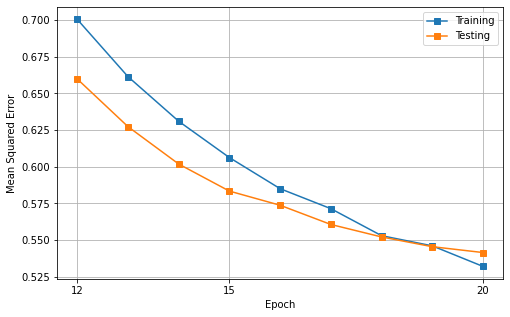

In [119]:
nn_plot_epoch_mse1(model,
                   mse_mean = None, # mean_squared_error(y_train, np.ones(shape = (len(y_train),))*np.mean(y_train))
                   start_epoch = 12,
                   title = "",
                   savefig = False,
                   img_file = "../img/accuracy_per_epoch.png"
                   )